# Model Prototype

### This notebook shows how to create a baseline model pipeline and save it

##### We save the Spark Dataframe as an Iceberg Table. Iceberg is a new open table format backed by Apple, Netflix and Cloudera. 
##### In the context of ML Ops, the most anticipated feature is Time Travel i.e. the ability to reproduce the data and the schema across different versions in time
##### Finally, we create a simple PySpark pipeline and train a classifier with Keras/Tensorflow

* For a more comprehensive demo of Iceberg in CML, please visit the [Spark3 Iceberg CML Github Repository](https://github.com/pdefusco/Spark3_Iceberg_CML)
* For a more detailed introduction to CML Session, Notebooks, and Spark tips and trips please visit the [CML Total Beginner GitHub Repository](https://github.com/pdefusco/CML-Total-Beginner)
* For a more comprehensive example of the Atlas Python client mentioned below, please visit the [Atlas Client Example Notebook in the Data Integration with ML GitHub Repository](https://github.com/pdefusco/Data_Integration_wMachineLearning/blob/main/2_A_Atlas_Client_Example.ipynb)

In [20]:
#spark.stop()

In [59]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import seaborn as sns
import matplotlib.pyplot as plt
import os
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

#### The Spark Session is created with the following configurations. If you get an error, ensure your CML Session is using Runtimes and Spark 3.1.

In [48]:
spark = SparkSession.builder\
  .appName("0.1 - Model Prototype") \
  .config("spark.kerberos.access.hadoopFileSystems", os.environ["STORAGE"])\
  .getOrCreate()
  #.config("spark.jars","/home/cdsw/lib/iceberg-spark3-runtime-0.9.1.1.13.317211.0-9.jar") \
  #.config("spark.sql.extensions","org.apache.iceberg.spark.extensions.IcebergSparkSessionExtensions") \
  #.config("spark.sql.catalog.spark_catalog","org.apache.iceberg.spark.SparkSessionCatalog") \
  #.config("spark.sql.catalog.spark_catalog.type","hive") \

#### Loading the data...

In [116]:
# Load and parse the data file, converting it to a DataFrame.
df = spark.read.csv(os.environ["STORAGE"]+'/datalake/model_factory/LoanStats_2015_subset_091322.csv',   
    header=True,
    sep=',',
    nullValue='NA')

In [51]:
df = df.limit(2000)

In [52]:
df.count()

2000

#### Investigating Target Class Imbalance

In [55]:
df.select("loan_status").distinct().show()

+------------------+
|       loan_status|
+------------------+
|       Charged Off|
|           Current|
|        Fully Paid|
|Late (31-120 days)|
|   In Grace Period|
| Late (16-30 days)|
+------------------+



In [56]:
#Types of loan status
print(df.groupBy('loan_status').count().show())

+------------------+-----+
|       loan_status|count|
+------------------+-----+
|       Charged Off|  311|
|           Current|  916|
|        Fully Paid|  721|
|Late (31-120 days)|   31|
|   In Grace Period|   11|
| Late (16-30 days)|   10|
+------------------+-----+

None


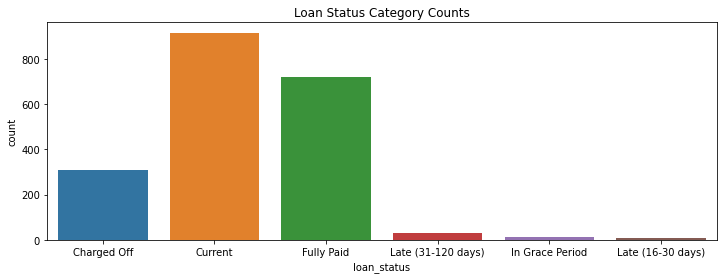

In [60]:
df_plot = df.groupBy('loan_status').count().toPandas()
plt.figure(figsize=(12,4))
g = sns.barplot(x="loan_status", y="count", data=df_plot)
g.set_title('Loan Status Category Counts')
plt.show()

We want to predict Default vs Non-Default Loan Applicants...

#### Creating the Target Feature

In [61]:
df = df.withColumn("label", when((df["loan_status"] == "Charged Off")|(df["loan_status"] == "Default"), 1).otherwise(0))

We start with a baseline...  we decide to start with only a few key features.

In [62]:
df = df.select(['acc_now_delinq', 'acc_open_past_24mths', 'annual_inc', 'avg_cur_bal', 'funded_amnt', 'label'])
df = df.dropna()

#### Let's create a simple Baseline Model Pipeline

In [63]:
train = df.sampleBy("label", fractions={0: 0.8, 1: 0.8}, seed=10)

In [64]:
test = df.subtract(train)

In [65]:
train.dtypes

[('acc_now_delinq', 'string'),
 ('acc_open_past_24mths', 'string'),
 ('annual_inc', 'string'),
 ('avg_cur_bal', 'string'),
 ('funded_amnt', 'string'),
 ('label', 'int')]

In [66]:
import random
import numpy as np
from pyspark.sql import Row
from sklearn import neighbors
from pyspark.ml.feature import VectorAssembler
from pyspark.mllib.stat import Statistics
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.mllib.stat import Statistics
from pyspark.ml.linalg import DenseVector
from pyspark.sql import functions as F

In [67]:
from handyspark import *

In [68]:
#Creates a Pipeline Object including One Hot Encoding of Categorical Features  
def make_pipeline(spark_df):        
     
    for c in spark_df.columns:
        spark_df = spark_df.withColumn(c, spark_df[c].cast("float"))
    
    stages= []

    cols = ['acc_now_delinq', 'acc_open_past_24mths', 'annual_inc', 'avg_cur_bal', 'funded_amnt']
    
    #Assembling mixed data type transformations:
    assembler = VectorAssembler(inputCols=cols, outputCol="features").setHandleInvalid("skip")
    stages += [assembler]    
    
    #Scaling features
    scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True)
    stages += [scaler]
    
    #Logistic Regression
    lr = LogisticRegression(featuresCol='scaledFeatures', labelCol='label', maxIter=100, regParam=0.0001, elasticNetParam=0.0001)
    stages += [lr]
    
    #Creating and running the pipeline:
    pipeline = Pipeline(stages=stages)
    pipelineModel = pipeline.fit(spark_df)

    return pipelineModel

In [69]:
pipelineModel = make_pipeline(train)

In [70]:
def cols_to_float(df):
    for c in df.columns:
        df = df.withColumn(c, df[c].cast("float"))
    return df

In [71]:
test = cols_to_float(test)
clf_out_df = pipelineModel.transform(test)

In [72]:
clf_out_df.select("label", "prediction").groupby('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0|  410|
+----------+-----+



In [73]:
clf_out_df.select("label", "prediction").groupby('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|  1.0|   67|
|  0.0|  343|
+-----+-----+



In [74]:
# Handy Spark Library 
# Creates instance of extended version of BinaryClassificationMetrics
# using a DataFrame and its probability and label columns, as the output
# from the classifier
bcm = BinaryClassificationMetrics(clf_out_df, scoreCol='probability', labelCol='label')

/opt/spark/python/lib/pyspark.zip/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.


/opt/spark/python/lib/pyspark.zip/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.


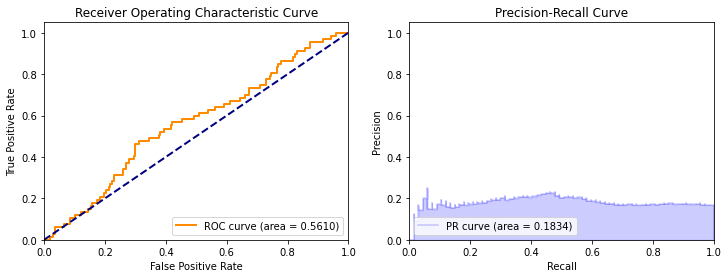

In [75]:
# Now we can PLOT both ROC and PR curves!
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
bcm.plot_roc_curve(ax=axs[0])
bcm.plot_pr_curve(ax=axs[1])
plt.show()

In [76]:
def get_confusion_matrix(spark_df):

    input_data = spark_df.rdd.map(lambda x: (x["label"], x["prediction"], float(x["probability"][1])))
    predictions = spark.createDataFrame(input_data, ["label", "prediction", "probability"])

    y_true = predictions.select(['label']).collect()
    y_pred = predictions.select(['prediction']).collect()

    from sklearn.metrics import classification_report, confusion_matrix
    print(classification_report(y_true, y_pred))
    cf_matrix = confusion_matrix(y_true, y_pred, labels=None, sample_weight=None, normalize=None)
    
    import seaborn as sns
    group_names = ["True Neg","False Pos","False Neg","True Pos"]
    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')


/home/cdsw/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cdsw/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cdsw/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.84      1.00      0.91       343
         1.0       0.00      0.00      0.00        67

    accuracy                           0.84       410
   macro avg       0.42      0.50      0.46       410
weighted avg       0.70      0.84      0.76       410



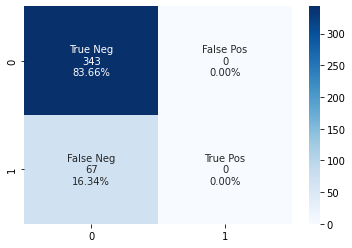

In [77]:
get_confusion_matrix(clf_out_df)

#### Time to train the classifier on the original data and deploy our scoring pipeline with CML Jobs

In [78]:
def score_data(df):
    
    #Scoring on the entire dataset now
    df = cols_to_float(df)
    pipelineModel = make_pipeline(df)
    scored_df = pipelineModel.transform(df)
    scored_df = scored_df.select("acc_now_delinq", "acc_open_past_24mths", "annual_inc", "avg_cur_bal", "funded_amnt", "label")

    return scored_df, pipelineModel

In [79]:
scored_df, pipelineModel = score_data(df)

In [80]:
#This is a sample of what we will save to the datawarehouse
scored_df.show(4)

+--------------+--------------------+----------+-----------+-----------+-----+
|acc_now_delinq|acc_open_past_24mths|annual_inc|avg_cur_bal|funded_amnt|label|
+--------------+--------------------+----------+-----------+-----------+-----+
|           0.0|                 6.0|   50050.0|      809.0|     8000.0|  1.0|
|           0.0|                 1.0|   80000.0|     3393.0|    20000.0|  1.0|
|           0.0|                13.0|   65000.0|     2003.0|     2000.0|  1.0|
|           0.0|                 7.0|  183000.0|    19827.0|    21000.0|  0.0|
+--------------+--------------------+----------+-----------+-----------+-----+
only showing top 4 rows



#### Convert Model to ONNX

In [88]:
import onnxruntime
import onnxmltools
import onnx
from onnxmltools.convert.common.data_types import FloatTensorType
from onnxmltools.convert.sparkml.utils import buildInitialTypesSimple

In [102]:
onnx_df = df.drop('label')

In [103]:
initial_types = onnxmltools.convert.sparkml.buildInitialTypesSimple(onnx_df)

In [104]:
initial_types

[('acc_now_delinq', FloatTensorType(shape=[1, 1])),
 ('acc_open_past_24mths', FloatTensorType(shape=[1, 1])),
 ('annual_inc', FloatTensorType(shape=[1, 1])),
 ('avg_cur_bal', FloatTensorType(shape=[1, 1])),
 ('funded_amnt', FloatTensorType(shape=[1, 1]))]

In [105]:
onnx_model = onnxmltools.convert.convert_sparkml(pipelineModel, 'My Sparkml Pipeline', initial_types)

The maximum opset needed by this model is only 8.


{'classlabels_ints': [0, 1],
 'coefficients': [0.009916418256512008,
                  -0.27396974376788374,
                  0.40361611425336275,
                  0.10315501432079811,
                  -0.16269287198820542,
                  -0.009916418256512008,
                  0.27396974376788374,
                  -0.40361611425336275,
                  -0.10315501432079811,
                  0.16269287198820542],
 'intercepts': [1.7468659229708499, -1.7468659229708499],
 'multi_class': 1,
 'name': 'LinearClassifier',
 'post_transform': 'LOGISTIC'}


In [113]:
with open("../models/model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

In [115]:
#spark.stop()

#### We will store the classifier locally but we could also use other storage options (S3, ADLS, GCS, HDFS, Ozone, etc.)

In [81]:
#def save_local_clf(clf_pipeline):
#    clf_pipeline.write().save("/home/cdsw/models")

#def save_s3_clf(clf_pipeline):
    #Saving pipeline to S3:
#    clf_pipeline.write().save(os.environ["STORAGE"]+"/datalake/pdefusco/pipeline")

In [83]:
#df = cols_to_float(df)

In [84]:
#def save_s3_data(df):
#    df.write.mode("overwrite").option("header", "true").parquet(os.environ["STORAGE"]+"/datalake/pdefusco/LoanStats_2015_subset.parquet") 
    
#df = spark.read.parquet('s3a://demo-aws-go02/datalake/pdefusco/LoanStats_2015_subset.parquet',   
#    header=True,
#    sep=',',
#    nullValue='NA')

In [114]:
#save_s3_data(df)